In [1]:
import pandas as pd
import numpy as np
import sys
import json 
import random
import math
import collections
import seaborn as sns
import networkx as nx
#!{sys.executable} -m pip install python-igraph
#!{sys.executable} -m pip install igraph
from collections import defaultdict
from scipy.stats.stats import pearsonr

from matplotlib import pyplot as plt
#!{sys.executable} -m pip install cdlib


import cdlib
from cdlib import algorithms as cd
from cdlib import readwrite, viz, evaluation

In [3]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn import preprocessing

# Static Community Discovery
## Preparation

In [12]:
G = nx.read_weighted_edgelist(f'../../data/tuscany_backboned.weighted.edgelist')
len(G.nodes)

15077

In [13]:

weights = [G.edges[edge]['weight'] for edge in G.edges()]
maxW = max(weights) 
for edge in G.edges():
    # G.edges[edge]['dissimilarity'] = 10000 - G.edges[edge]['weight']
    G.edges[edge]['dissimilarity'] =  maxW+1 - G.edges[edge]['weight']

In [14]:
components =  [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
avg_size = np.average([len(c) for c in components[1:]])
print('average componets size: ', avg_size)
print(len(components))
print([len(c) for c in components[:20]],'etc...')

C = G.subgraph(components[0]).copy()


average componets size:  2.176470588235294
35
[15003, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] etc...


In [7]:
import pandas as pd
df = pd.read_csv("../data/geotuscany.csv",index_col=0)

#for node in C.nodes():
  #  C.nodes[node]['name'] = df.loc[int(node),'name']
    
df.head()

,position,name,city,menu,link,score,N_reviews,price,Name,Province,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,lucca,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,551,Acino Bianco,Marina di Massa,False,/Restaurant_Review-g194814-d12843022-Reviews-A...,4.5,92,2.5,Acino Bianco,massacarrara,...,44.004616,10.115488,Italian,Dinner,"Vegetarian Friendly, Gluten Free Options",yEU_https://maps.google.com/maps?saddr=&daddr=...,lucca,/Restaurant_Review-g194814-d12843022-Reviews-A...,0,NaN
2,308,El Artista Ristorante Argentino,Massa,False,/Restaurant_Review-g660766-d17543924-Reviews-E...,4.5,78,2.5,El Artista Ristorante Argentino,massacarrara,...,44.041000,10.124396,"Barbecue, Argentinean, Steakhouse","Dinner, Lunch",NaN,U0P_https://maps.google.com/maps?saddr=&daddr=...,lucca,/Restaurant_Review-g660766-d17543924-Reviews-E...,0,NaN
3,1285,La Locanda di Bivigliano,Bivigliano,False,/Restaurant_Review-g1957776-d13948598-Reviews-...,NaN,28,NaN,La Locanda di Bivigliano,florence,...,43.893859,11.322421,"Italian, Mediterranean, Barbecue, Tuscan, Cent...",NaN,Vegetarian Friendly,rg1_https://maps.google.com/maps?saddr=&daddr=...,prato,/Restaurant_Review-g1957776-d13948598-Reviews-...,0,NaN
4,1499,Beach Bar @PuntAla,Punta Ala,False,/Restaurant_Review-g194871-d19315573-Reviews-B...,2.5,2,1.0,Beach Bar @PuntAla,grosseto,...,42.841410,10.775602,"Italian, Mediterranean","Lunch, Brunch, Drinks",NaN,32Q_https://maps.google.com/maps?saddr=&daddr=...,grosseto,/Restaurant_Review-g194871-d19315573-Reviews-B...,1,NaN


In [9]:
for i in  df[(df.latitude.isna()) | (df.longitude.isna())].index:
    prov = df.loc[i,'province']
    df.loc[i,'latitude'] = np.mean(df.loc[(~df.latitude.isna()) & (df.province == prov),'latitude'])
    df.loc[i,'longitude'] = np.mean(df.loc[(~df.longitude.isna()) & (df.province == prov),'longitude']) 

In [10]:
df = df.loc[[int(node) for node in C.nodes]].copy()
print(len(df))

15003


In [13]:
df.reset_index(inplace=True)
index_map = {str(old):new for new,old in df['index'].items()}
G = nx.relabel_nodes(C, index_map) 
for node in G.nodes: G.nodes[node]['province'] = df.loc[node,'province']

In [15]:
df.to_csv('../data/connencted.csv')
nx.write_weighted_edgelist(G,'../data/connected.weighted.edgelist')

## Data Loading

In [67]:
G = nx.read_weighted_edgelist('../data/connected.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connencted.csv',index_col=0)
for node in G.nodes:
    G.nodes[node]['province'] = df.loc[node,'province']

weights = [G.edges[edge]['weight'] for edge in G.edges()]
maxW = max(weights) 
for edge in G.edges():
    # G.edges[edge]['dissimilarity'] = 10000 - G.edges[edge]['weight']
    G.edges[edge]['dissimilarity'] =  maxW+1 - G.edges[edge]['weight']
    
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,43.798058,11.219482,"Italian, Pizza, Mediterranean, Tuscan, Central...",NaN,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN
2,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,43.764280,11.180183,"Italian, Pizza, Seafood, Mediterranean",NaN,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN
3,48,1301,Bar Pasticceria Deanna,Florence,False,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,4.0,162,1.0,Bar Pasticceria Deanna,...,43.775550,11.247292,"Italian, Bar, Cafe, Deli",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",hSR_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,1,NaN
4,50,1332,Perseus Fiesolano,Fiesole,True,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,3.5,754,2.5,Perseus Fiesolano,...,43.806915,11.293199,"Italian, Mediterranean, Barbecue, Tuscan, Cent...","Lunch, Dinner",Gluten Free Options,d5H_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,1,NaN


In [5]:
def assign(g,communities, attribute, overlap=False):
    
    if ~overlap:
        
        for label, community in enumerate(communities.communities):
            for node in community:
                g.nodes[node][attribute] = label
                
    else: 
        
        for node in g.nodes:
            g.nodes[node][attribute] = list()
            
        for label, community in enumerate(communities.communities):
            g.nodes[node][attribute].append(label)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

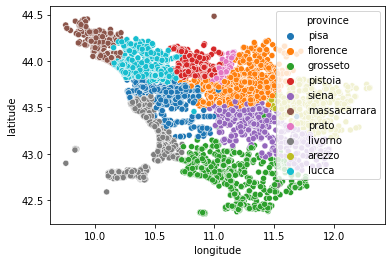

In [4]:
sns.scatterplot(data = df, x='longitude',y='latitude',hue='province')

In [176]:
provincemapping = {e:i for i,e in enumerate(df.province.unique())}

In [180]:
provinces =  {"communities":[[] for _ in df['province'].unique()]}
for i, c in df['province'].items():
    provinces['communities'][provincemapping[c]].append(i)
   
provinces["algorithm"] = 'provinces'
provinces["params"] =  {"initial_membership": None, "weights": None}
provinces["overlap"] = False
provinces["coverage"]= 1.0
with open('../data/communities/provinces.json','w+') as jf:
    json.dump(provinces, jf)


## Crisp Communities

### K means 
Use longitude and latitude

In [8]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(df_clust)
print(pd.Series(kmeans.labels_).value_counts())

3    3452
4    2439
7    1946
1    1615
8    1144
9    1095
2    1060
0    1053
6     751
5     448
dtype: int64


In [9]:
df['kmeans'] = kmeans.labels_.astype(str)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

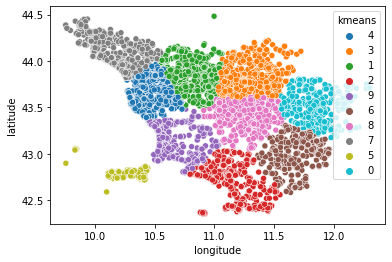

In [10]:
sns.scatterplot(data = df, x='longitude',y='latitude',hue='kmeans')

In [11]:
data = {"communities":[[] for _ in df['kmeans'].unique()]}
for i, c in df['kmeans'].items():
    data['communities'][int(c)].append(i)
    
with open('../data/communities/kmeans.json','w+') as jf:
    json.dump(data, jf)

    


In [12]:
for node in G.nodes:
    G.nodes[node]['kmeans'] = df.loc[node,'kmeans']

### Louvain

In [57]:
louvain = cd.louvain(G, resolution=1)
print(len(louvain.communities),[len(c) for c in louvain.communities ])

79 [3083, 2357, 1891, 796, 700, 674, 513, 456, 434, 382, 360, 350, 249, 216, 199, 192, 186, 169, 156, 152, 143, 135, 127, 94, 88, 88, 73, 62, 58, 52, 44, 43, 42, 34, 31, 31, 30, 26, 26, 25, 22, 19, 19, 15, 13, 10, 9, 8, 8, 7, 7, 6, 6, 6, 6, 6, 6, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2]


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

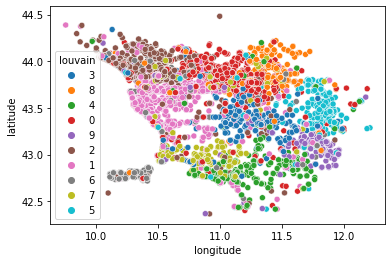

In [59]:
readwrite.write_community_json(louvain,'../data/communities/louvain.json')
assign(G,louvain,'louvain')
for node in G.nodes:
    df.loc[node,'louvain'] = str(G.nodes[node]['louvain'])

sns.scatterplot(data = df[df.louvain.astype(int)<10], x='longitude',y='latitude',hue='louvain')

### greedy modularity

In [60]:
greedy_modularity = cd.greedy_modularity(G)
readwrite.write_community_json(greedy_modularity,'../data/communities/greedy_modularity.json')


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

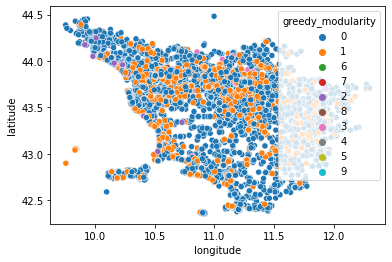

In [61]:
assign(G,greedy_modularity,'greedy_modularity')
for node in G.nodes:
    df.loc[node,'greedy_modularity'] = str(G.nodes[node]['greedy_modularity'])

sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='greedy_modularity')

### Leiden

In [62]:
leiden= cd.leiden(G)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

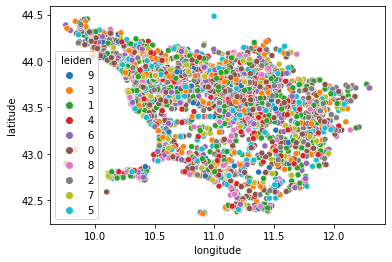

In [63]:
readwrite.write_community_json(leiden,'../data/communities/leiden.json')
assign(G,leiden,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])

sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

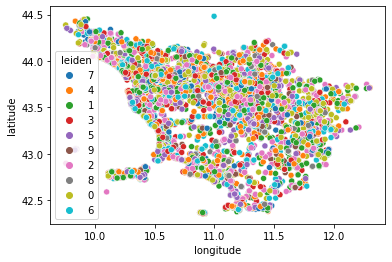

In [68]:
provincemapping = {e:i for i,e in enumerate(df.province.unique())}
for node in G.nodes:
    G.nodes[node]['provint'] = provincemapping[df.loc[node,'province']]
    
leiden_p= cd.leiden(G, initial_membership = [G.nodes[node]['provint'] for node in G.nodes], weights='dissimilarity')
readwrite.write_community_json(leiden_p,'../data/communities/leiden_wp.json')
assign(G,leiden_p,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])
sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

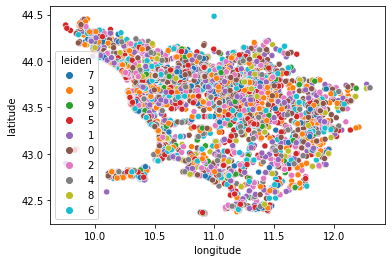

In [69]:
leiden_p= cd.leiden(G, initial_membership = [G.nodes[node]['provint'] for node in G.nodes])
readwrite.write_community_json(leiden_p,'../data/communities/leiden_p.json')
assign(G,leiden_p,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])
sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

### Label Propagation

In [41]:
label_propagation = cd.label_propagation(G)
readwrite.write_community_json(label_propagation,'../data/communities/label_propagation.json')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

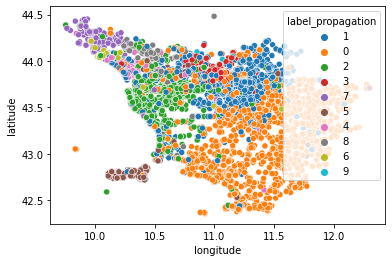

In [46]:

assign(G,label_propagation,'label_propagation')
for node in G.nodes:
    df.loc[node,'label_propagation'] = str(G.nodes[node]['label_propagation'])

sns.scatterplot(data = df[df.label_propagation.astype(int)<10], x='longitude',y='latitude',hue='label_propagation')

### Async Fluid


In [16]:
async_fluid = cd.async_fluid(G,k=5)
readwrite.write_community_json(async_fluid,'../data/communities/async_fluid.json')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

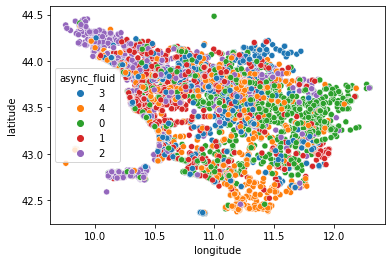

In [54]:
assign(G,async_fluid,'async_fluid')
for node in G.nodes:
    df.loc[node,'async_fluid'] = str(G.nodes[node]['async_fluid'])

sns.scatterplot(data = df[df.async_fluid.astype(int)<10], x='longitude',y='latitude',hue='async_fluid')

### Rb / Rber Pots

In [149]:

provinceMapping= { p:i for i,p in enumerate(df.province.unique())}
for node in G.nodes:
     G.nodes[node]['provint'] = provinceMapping[G.nodes[node]['province']]
                                            

In [154]:
for node in list(G.nodes())[:10]: print(G.nodes[node])

{'province': 'pisa', 'provint': 0, 'size': 6}
{'province': 'florence', 'provint': 1, 'size': 229}
{'province': 'florence', 'provint': 1, 'size': 236}
{'province': 'florence', 'provint': 1, 'size': 162}
{'province': 'florence', 'provint': 1, 'size': 754}
{'province': 'florence', 'provint': 1, 'size': 215}
{'province': 'florence', 'provint': 1, 'size': 61}
{'province': 'florence', 'provint': 1, 'size': 291}
{'province': 'grosseto', 'provint': 2, 'size': 239}
{'province': 'pistoia', 'provint': 3, 'size': 147}


In [75]:

rb_pots = cd.rb_pots( G, initial_membership =[G.nodes[node]['provint'] for node in G.nodes()], resolution_parameter=0.7)


readwrite.write_community_json(rb_pots,'../data/communities/rb_pots.json')
print(len(rb_pots.communities))

15


In [71]:
for c in rb_pots.communities: print(len(c))

3335
2929
2712
2508
1741
1008
415
149
65
53
51
21
6
5
5


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

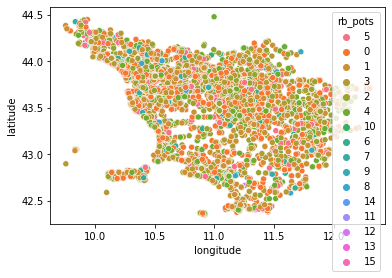

In [66]:
assign(G,rb_pots,'rb_pots')
for node in G.nodes:
    df.loc[node,'rb_pots'] = str(G.nodes[node]['rb_pots'])

sns.scatterplot(data = df[df.rb_pots.astype(int)<20], x='longitude',y='latitude',hue='rb_pots')

In [156]:
for node in G.nodes: G.nodes[node]['size'] = int(df.loc[node,'N_reviews'])

In [157]:
rber_pots = cd.rber_pots(G, initial_membership =[G.nodes[node]['provint'] for node in G.nodes()],node_sizes=[G.nodes[node]['size'] for node in G.nodes()] ,weights='dissimilarity',resolution_parameter=0.7)
readwrite.write_community_json(rber_pots,'../data/communities/rber_pots.json')
print(len(rber_pots.communities))

796


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

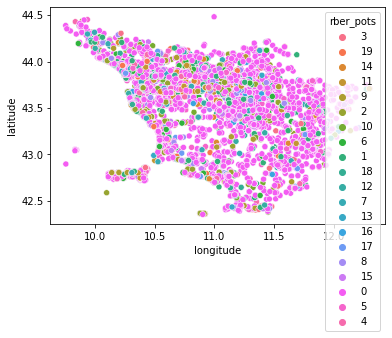

In [68]:
assign(G,rber_pots,'rber_pots')
for node in G.nodes:
    df.loc[node,'rber_pots'] = str(G.nodes[node]['rber_pots'])

sns.scatterplot(data = df[df.rber_pots.astype(int)<20], x='longitude',y='latitude',hue='rber_pots')

## Overlapping Communities

### Angel 

In [7]:
angel = cd.angel(G, min_community_size=10, threshold=0.2)
readwrite.write_community_json(angel,'../data/communities/angel.json')

In [8]:
print(len(angel.communities))
print([len(c) for c in angel.communities ])

3
[8076, 95, 10]


In [30]:
assign(G,angel,'angel',overlap=True)


#sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='angel')

### Demon

In [72]:
demon = cd.demon(G, min_com_size=10,epsilon=0.1)
print(len(demon.communities))
readwrite.write_community_json(demon,'../data/communities/demon.json')

In [73]:
print(len(demon.communities))

220


## Attribute Comunities
### Ilouvain

In [79]:
G = nx.read_weighted_edgelist('../data/connected.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connencted.csv',index_col=0)
maxW = max([ G.edges[edge]['weight'] for edge in G.edges]) 
for edge in G.edges():
    # G.edges[edge]['dissimilarity'] = 10000 - G.edges[edge]['weight']
    G.edges[edge]['weight'] =  maxW+1 - G.edges[edge]['weight']
    
for node in list(G.nodes)[:10]: print(node,G.nodes[node])

0 {}
1 {}
2 {}
3 {}
4 {}
5 {}
6 {}
8 {}
9 {}
14 {}


In [80]:
print(len(G), max([node for node in G.nodes]))

15003 15002


In [81]:
df.isnull().sum()

index                   0
position                0
name                    0
city                    2
menu                    0
link                    0
score                 518
N_reviews               0
price                2892
Name                    0
Province                0
City                    0
claimed                 0
covidMeasure            0
travellersChoice        0
latitude                0
longitude               0
cuisines             1337
meals                6281
specialDiets         8389
positionlink            1
province                0
Link                 1752
provinceOK              0
longitud§e          14237
dtype: int64

In [82]:
for node in G.nodes: G.nodes[node]['province'] = None#df.loc[node,'province']

In [23]:
provincemapping = {e:i for i,e in enumerate(df.province.unique())}
for node in G.nodes:
    G.nodes[node]['provint'] = provincemapping[df.loc[node,'province']]
    

In [ ]:
provincemapi

In [83]:
attributes = ['latitude','longitude','N_reviews','covidMeasure','travellersChoice','claimed','menu']

In [84]:
for node in G.nodes:
    for attr in attributes: 
        G.nodes[node][attr] = float(df.loc[node,attr])

In [85]:
for node in list(G.nodes)[:10]: print(node,G.nodes[node])

0 {'province': None, 'latitude': 43.85180773789867, 'longitude': 10.506207, 'N_reviews': 6.0, 'covidMeasure': 0.0, 'travellersChoice': 0.0, 'claimed': 1.0, 'menu': 0.0}
1 {'province': None, 'latitude': 43.798058, 'longitude': 11.219482, 'N_reviews': 229.0, 'covidMeasure': 1.0, 'travellersChoice': 1.0, 'claimed': 1.0, 'menu': 1.0}
2 {'province': None, 'latitude': 43.76428, 'longitude': 11.180183, 'N_reviews': 236.0, 'covidMeasure': 0.0, 'travellersChoice': 1.0, 'claimed': 1.0, 'menu': 0.0}
3 {'province': None, 'latitude': 43.77555, 'longitude': 11.247292, 'N_reviews': 162.0, 'covidMeasure': 0.0, 'travellersChoice': 0.0, 'claimed': 1.0, 'menu': 0.0}
4 {'province': None, 'latitude': 43.806915, 'longitude': 11.293199, 'N_reviews': 754.0, 'covidMeasure': 0.0, 'travellersChoice': 0.0, 'claimed': 1.0, 'menu': 1.0}
5 {'province': None, 'latitude': 43.76676, 'longitude': 11.247868, 'N_reviews': 215.0, 'covidMeasure': 0.0, 'travellersChoice': 1.0, 'claimed': 0.0, 'menu': 0.0}
6 {'province': None

In [86]:
labels = { int(node) : {attr:int(G.nodes[node][attr]) for attr in attributes} for node in G.nodes()}


In [87]:

ilouvain = cd.ilouvain(G,labels,{node:node for node in G.nodes})

MemoryError: Unable to allocate 1.68 GiB for an array with shape (225090009,) and data type float64

In [ ]:

readwrite.write_community_json(ilouvain,'../data/communities/ilouvain.json')

## Evaluation


In [2]:
G = nx.read_weighted_edgelist('../data/connected.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connencted.csv',index_col=0)
#for node in G.nodes:
 #   G.nodes[node]['province'] = df.loc[node,'province']
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,43.798058,11.219482,"Italian, Pizza, Mediterranean, Tuscan, Central...",NaN,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN
2,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,43.764280,11.180183,"Italian, Pizza, Seafood, Mediterranean",NaN,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN
3,48,1301,Bar Pasticceria Deanna,Florence,False,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,4.0,162,1.0,Bar Pasticceria Deanna,...,43.775550,11.247292,"Italian, Bar, Cafe, Deli",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",hSR_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,1,NaN
4,50,1332,Perseus Fiesolano,Fiesole,True,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,3.5,754,2.5,Perseus Fiesolano,...,43.806915,11.293199,"Italian, Mediterranean, Barbecue, Tuscan, Cent...","Lunch, Dinner",Gluten Free Options,d5H_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,1,NaN


In [5]:
nx.is_connected(G)

True

In [5]:
import os 
data = dict()


for f in os.listdir('../data/communities'):
    if f[-5:] != '.json': continue
   
    name = f[:-5]
    
    communities = readwrite.read_community_json(f'../data/communities/{f}')
    data[name] = communities
    print(name,' -> ',len(communities.communities),' -> ', [len(c) for c in communities.communities[:20]])

provinces  ->  10  ->  [3645, 1949, 1796, 1647, 1571, 1460, 1124, 967, 791, 535]
kmeans  ->  10  ->  [3599, 2548, 2045, 1712, 1135, 1115, 1069, 1055, 759, 448]
louvain  ->  17  ->  [2463, 2409, 1894, 1847, 1839, 1336, 1225, 877, 537, 455, 389, 165, 20, 11, 11, 6, 1]
greedy_modularity  ->  1  ->  [15485]
weighted_greedy_modularity  ->  15484  ->  [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
leiden  ->  13  ->  [2387, 2348, 1839, 1824, 1566, 1424, 1353, 936, 580, 536, 499, 188, 5]
weighted_leiden  ->  18  ->  [2268, 2119, 1821, 1757, 1677, 1420, 1099, 965, 644, 606, 426, 332, 280, 39, 21, 6, 4, 1]
leiden_wp  ->  17  ->  [2970, 2323, 1969, 1874, 1705, 1175, 1075, 904, 554, 464, 384, 42, 13, 11, 9, 8, 5]
leiden_p  ->  15  ->  [2562, 2239, 1860, 1836, 1786, 1718, 1355, 916, 599, 526, 39, 17, 13, 12, 7]
label_propagation  ->  118  ->  [15066, 83, 16, 14, 8, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
async_fluid10  ->  10  ->  [1767, 1617, 1606, 1586, 1576, 1558, 1472, 1470,

### Collect Fitness

In [7]:
all_evalution_functions = [evaluation.avg_distance, evaluation.avg_embeddedness, evaluation.average_internal_degree, evaluation.avg_transitivity, evaluation.conductance, evaluation.cut_ratio, evaluation.edges_inside, evaluation.expansion,  evaluation.fraction_over_median_degree,  evaluation.hub_dominance,  evaluation.internal_edge_density, evaluation.normalized_cut, evaluation.max_odf, evaluation.avg_odf, evaluation.flake_odf, evaluation.scaled_density, evaluation.significance, evaluation.size , evaluation.surprise , evaluation.triangle_participation_ratio, evaluation.purity]  

In [8]:
evaluation_functions = [ evaluation.avg_embeddedness, evaluation.average_internal_degree, evaluation.avg_transitivity, evaluation.conductance, evaluation.cut_ratio, evaluation.edges_inside, evaluation.expansion,  evaluation.fraction_over_median_degree,  evaluation.hub_dominance,  evaluation.internal_edge_density, evaluation.normalized_cut, evaluation.max_odf, evaluation.avg_odf, evaluation.flake_odf, evaluation.scaled_density, evaluation.significance, evaluation.size , evaluation.surprise , evaluation.triangle_participation_ratio]  

In [9]:
scores = {name:{} for name in data.keys() }
for evaluation_function in evaluation_functions:
    f_name = str(evaluation_function).split(' ')[1].upper()
    print(f_name)
    for name, comm in data.items():
        print(name,end= ' -> ')
        try: 
            ev = evaluation_function(G,comm)
            print(ev)
            scores[name][f_name] = ev.score
            
        except Exception as e: 
            print(e) 
            scores[name][f_name] = np.nan
            
    print('\n\n')

AVG_EMBEDDEDNESS
angel -> FitnessResult(min=0.0, max=0.6057805107395245, score=0.22928925294166938, std=0.2683204917919616)
async_fluid_5 -> FitnessResult(min=0.6030970334195757, max=0.7141848199607456, score=0.6474132275106634, std=0.0385441850797324)
async_fluid_7 -> FitnessResult(min=0.5857753954660431, max=0.6872416565150626, score=0.6288728811292638, std=0.032873228533212465)
demon -> FitnessResult(min=0.13116230559654155, max=0.8247654019763412, score=0.38745127698592213, std=0.08013841666996586)
kmeans -> FitnessResult(min=0.48803864266821867, max=0.6765166289161176, score=0.5897501979047435, std=0.06698157252254024)
label_propagation -> FitnessResult(min=0.15476190476190477, max=0.9, score=0.5933040659443446, std=0.14979176414645512)
leiden_p -> FitnessResult(min=0.0, max=0.3519661403457961, score=0.09259031607685614, std=0.08843330539501343)
rber_pots -> FitnessResult(min=0.0, max=0.8041308578852961, score=0.006971607990891248, std=0.04283593344237097)
provinces -> FitnessResu

leiden -> FitnessResult(min=0.7633036359258367, max=0.9866666666666667, score=0.9070989653722532, std=0.06353628506071209)
leiden_wp -> FitnessResult(min=0.761804745235317, max=1.0, score=0.9261244466929481, std=0.07373519198778491)
weighted_rb_pots -> FitnessResult(min=0.6977901707912164, max=1.0, score=0.9009266898213131, std=0.11075440079846609)
rb_pots -> FitnessResult(min=0.7273902412434394, max=1.0, score=0.8992600543356883, std=0.0917223712636496)



CUT_RATIO
angel -> FitnessResult(min=0.0010859587928770142, max=0.001874207963716401, score=0.0013600165797328229, std=0.00036385189036601767)
async_fluid_5 -> FitnessResult(min=0.000450682027210178, max=0.0006539009087498778, score=0.0005516442037484151, std=7.489160490193442e-05)
async_fluid_7 -> FitnessResult(min=0.0004398661901350327, max=0.0006288574089645529, score=0.0005219090438886248, std=6.288690883536811e-05)
demon -> FitnessResult(min=0.00027282753816683115, max=0.0023345784418356457, score=0.0014075396639502192, std=0.0

weighted_louvain -> FitnessResult(min=1, max=54, score=32.80952380952381, std=16.9357864204177)
louvain -> FitnessResult(min=1, max=59, score=18.17721518987342, std=19.191743671595475)
weighted_greedy_modularity -> FitnessResult(min=1, max=53, score=3.8358208955223883, std=8.369448732582367)
greedy_modularity -> FitnessResult(min=1, max=53, score=3.8358208955223883, std=8.369448732582367)
leiden -> FitnessResult(min=48, max=99, score=71.41176470588235, std=12.742050917795593)
leiden_wp -> FitnessResult(min=12, max=92, score=62.80952380952381, std=19.06534889123908)
weighted_rb_pots -> FitnessResult(min=26, max=96, score=61.46666666666667, std=18.23500906376401)
rb_pots -> FitnessResult(min=30, max=96, score=67.66666666666667, std=14.35115171529991)



AVG_ODF
angel -> FitnessResult(min=7.757429420505201, max=28.1, score=17.348967701571908, std=8.345192796960195)
async_fluid_5 -> FitnessResult(min=5.312189054726368, max=7.779459111397296, score=6.61497804864717, std=0.8570066855623557)


/home/ec2-user/.local/lib/python3.7/site-packages/cdlib/evaluation/fitness.py:812: RuntimeWarning: divide by zero encountered in log
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))
/home/ec2-user/.local/lib/python3.7/site-packages/cdlib/evaluation/fitness.py:812: RuntimeWarning: invalid value encountered in double_scalars
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))


FitnessResult(min=None, max=None, score=nan, std=None)
async_fluid_5 -> FitnessResult(min=None, max=None, score=397966.57826587313, std=None)
async_fluid_7 -> FitnessResult(min=None, max=None, score=421808.9734925168, std=None)
demon -> FitnessResult(min=None, max=None, score=3347546.3649165737, std=None)
kmeans -> FitnessResult(min=None, max=None, score=402579.02546301525, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=nan, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=nan, std=None)
rber_pots -> FitnessResult(min=None, max=None, score=nan, std=None)
provinces -> FitnessResult(min=None, max=None, score=408643.9386856163, std=None)
weighted_leiden -> FitnessResult(min=None, max=None, score=nan, std=None)
weighted_louvain -> FitnessResult(min=None, max=None, score=494368.0959817263, std=None)
louvain -> FitnessResult(min=None, max=None, score=nan, std=None)
weighted_greedy_modularity -> FitnessResult(min=None, max=None, score=nan, std=None)
greedy

/home/ec2-user/.local/lib/python3.7/site-packages/cdlib/evaluation/fitness.py:769: RuntimeWarning: invalid value encountered in log2
  sp = m * (q * np.log(q / qa) + (1 - q) * np.log2((1 - q) / (1 - qa)))


FitnessResult(min=None, max=None, score=nan, std=None)
kmeans -> FitnessResult(min=None, max=None, score=58277.06728215988, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=74770.77951112443, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=-1322.8646505682314, std=None)
rber_pots -> FitnessResult(min=None, max=None, score=1866.3844360578048, std=None)
provinces -> FitnessResult(min=None, max=None, score=61775.45701246686, std=None)
weighted_leiden -> FitnessResult(min=None, max=None, score=-1105.6329491986808, std=None)
weighted_louvain -> FitnessResult(min=None, max=None, score=108238.39141577113, std=None)
louvain -> FitnessResult(min=None, max=None, score=96646.0997783145, std=None)
weighted_greedy_modularity -> FitnessResult(min=None, max=None, score=36735.71592007527, std=None)
greedy_modularity -> FitnessResult(min=None, max=None, score=36735.71592007527, std=None)
leiden -> FitnessResult(min=None, max=None, score=-1192.8014288370607, std=None)

In [10]:
f_df = pd.DataFrame(scores)#, index = [name for name in data.keys()],columns = [str(evaluation_function).split(' ')[1].upper() for evaluation_function in evaluation_functions])

f_df

,angel,async_fluid_5,async_fluid_7,demon,kmeans,label_propagation,leiden_p,rber_pots,provinces,weighted_leiden,weighted_louvain,louvain,weighted_greedy_modularity,greedy_modularity,leiden,leiden_wp,weighted_rb_pots,rb_pots
AVG_EMBEDDEDNESS,0.229289,0.647413,0.628873,3.874513e-01,0.589750,0.593304,0.092590,0.006972,0.601829,0.091709,0.701913,0.709155,0.766074,0.766074,0.110566,0.088229,0.112544,0.118142
AVERAGE_INTERNAL_DEGREE,4.556168,11.445435,11.101579,1.288944e+01,10.462893,2.273236,1.370315,0.055473,10.778917,1.343281,11.036344,4.987877,2.990350,2.990350,1.629297,1.302677,1.729772,1.761251
AVG_TRANSITIVITY,0.086832,0.196938,0.203799,6.034796e-01,0.170878,0.111294,0.061757,0.002904,0.168455,0.069606,0.263615,0.147590,0.045763,0.045763,0.079797,0.057599,0.062921,0.074292
CONDUCTANCE,0.775809,0.368465,0.387894,6.219615e-01,0.442512,0.487978,0.921651,0.995715,0.425130,0.923741,0.325605,0.370761,0.304884,0.304884,0.907099,0.926124,0.900927,0.899260
CUT_RATIO,0.001360,0.000552,0.000522,1.407540e-03,0.000601,0.000136,0.001069,0.000714,0.000580,0.001080,0.000386,0.000230,0.000065,0.000065,0.001142,0.001084,0.001136,0.001148
EDGES_INSIDE,17277.666667,17392.200000,12277.571429,2.231627e+03,7980.800000,155.578947,1004.300000,121.006281,8012.700000,777.190476,4188.333333,1089.886076,1956.656716,1956.656716,1046.117647,947.428571,2116.066667,1685.866667
EXPANSION,17.348968,6.614978,6.698830,2.067839e+01,8.149616,2.033811,15.170720,10.693509,7.836483,15.372690,5.455560,3.359499,0.942073,0.942073,16.104925,15.438975,15.890723,16.063637
FRACTION_OVER_MEDIAN_DEGREE,0.279402,0.478097,0.477606,4.682500e-01,0.482276,0.202860,0.276285,0.019455,0.480014,0.316737,0.454226,0.344431,0.240187,0.240187,0.380210,0.287662,0.300613,0.321487
HUB_DOMINANCE,0.031258,0.026817,0.033560,2.651779e-01,0.047249,0.924132,0.020685,NaN,0.046773,0.033899,0.204365,0.476582,0.843093,0.843093,0.026743,0.019734,0.033280,0.022280
INTERNAL_EDGE_DENSITY,0.000879,0.000951,0.001272,2.320763e-02,0.002353,0.179321,0.000554,0.001541,0.002277,0.001783,0.021822,0.076098,0.159687,0.159687,0.000762,0.000761,0.001425,0.000608


In [11]:
f_df.to_csv('../data/fitnessMeasures.csv')

### Collect Modularities

In [6]:
all_modularities = [evaluation.erdos_renyi_modularity, evaluation.link_modularity , evaluation.modularity_density , evaluation.newman_girvan_modularity , evaluation.z_modularity]

In [7]:
scores = {name:{} for name in data.keys() }
for modularity in all_modularities:
    m_name = str(modularity).split(' ')[1].upper()
    print(m_name)
    for name, comm in data.items():
        print(name,end= ' -> ')
        try: 
            mod=modularity(G,comm)
            print(mod)
            scores[name][m_name] = mod.score
            
        except Exception as e:
            print(e) 
            scores[name][m_name] = np.nan
            
    print('\n\n')

ERDOS_RENYI_MODULARITY
provinces -> FitnessResult(min=None, max=None, score=0.04581116616368504, std=None)
kmeans -> FitnessResult(min=None, max=None, score=0.029764104573784516, std=None)
louvain -> FitnessResult(min=None, max=None, score=0.036574947326543684, std=None)
greedy_modularity -> FitnessResult(min=None, max=None, score=0.0, std=None)
weighted_greedy_modularity -> FitnessResult(min=None, max=None, score=0.0, std=None)
leiden -> FitnessResult(min=None, max=None, score=0.003429089527164503, std=None)
weighted_leiden -> FitnessResult(min=None, max=None, score=0.0019162848915685491, std=None)
leiden_wp -> FitnessResult(min=None, max=None, score=0.002330888252150414, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=0.0037835965638288544, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=-0.001593962654794282, std=None)
async_fluid10 -> FitnessResult(min=None, max=None, score=0.02627573150237818, std=None)
async_fluid7 -> FitnessResult(min=None, m

/home/ec2-user/.local/lib/python3.7/site-packages/cdlib/evaluation/fitness.py:722: RuntimeWarning: invalid value encountered in double_scalars
  res = (mmc - dc2m) / np.sqrt(dc2m * (1 - dc2m))


FitnessResult(min=None, max=None, score=nan, std=None)
weighted_greedy_modularity -> FitnessResult(min=None, max=None, score=-0.010676605112253585, std=None)
leiden -> FitnessResult(min=None, max=None, score=0.009390174328962452, std=None)
weighted_leiden -> FitnessResult(min=None, max=None, score=0.008091947712143407, std=None)
leiden_wp -> FitnessResult(min=None, max=None, score=0.006533923711684675, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=0.012149593118947147, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=0.0034356168488820257, std=None)
async_fluid10 -> FitnessResult(min=None, max=None, score=0.08104855341549823, std=None)
async_fluid7 -> FitnessResult(min=None, max=None, score=0.07379159616532638, std=None)
rb_pots -> FitnessResult(min=None, max=None, score=0.004875690645257487, std=None)
rber_pots -> FitnessResult(min=None, max=None, score=0.0021446739274963416, std=None)
angel -> FitnessResult(min=None, max=None, score=0.00065636034

In [8]:
m_df = pd.DataFrame(scores)#, index = [name for name in data.keys()],columns = [str(modularity).split(' ')[1].upper() for modularity in all_modularities])
m_df

,provinces,kmeans,louvain,greedy_modularity,weighted_greedy_modularity,leiden,weighted_leiden,leiden_wp,leiden_p,label_propagation,async_fluid10,async_fluid7,rb_pots,rber_pots,angel,demon
ERDOS_RENYI_MODULARITY,0.045811,0.029764,0.036575,0.000000,0.000000,0.003429,0.001916,0.002331,0.003784,-0.001594,0.026276,0.026084,0.002871,0.002035,0.003984,0.073546
LINK_MODULARITY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MODULARITY_DENSITY,-125.321080,-137.166874,-236.070327,18.215824,-273292.000000,-194.828222,-267.586643,-268.012064,-225.247641,-1817.373527,-136.099531,-84.554841,-138.916531,-14564.936375,-86.591610,-2291.260406
NEWMAN_GIRVAN_MODULARITY,0.114822,0.081066,0.084890,0.000000,-0.000199,0.013495,0.011343,0.016333,0.016612,0.002022,0.060577,0.069750,0.016066,0.003295,-0.269234,0.003269
Z_MODULARITY,0.133405,0.089661,0.107718,NaN,-0.010677,0.009390,0.008092,0.006534,0.012150,0.003436,0.081049,0.073792,0.004876,0.002145,0.000656,0.147404


In [9]:
m_df.to_csv('../data/modularityMeasures.csv')

In [16]:
m_df.transpose()

,ERDOS_RENYI_MODULARITY,LINK_MODULARITY,MODULARITY_DENSITY,NEWMAN_GIRVAN_MODULARITY,Z_MODULARITY
angel,0.089541,NaN,-38.378399,-0.244769,0.019254
async_fluid_5,0.434518,0.092060,24.152286,0.518360,1.055664
async_fluid_7,0.483990,0.090983,30.819237,0.585708,1.298426
demon,3.454054,0.123409,-1713.568821,0.147370,6.145115
kmeans,0.451871,0.084488,23.132766,0.661938,1.364148
label_propagation,0.518913,0.097010,141.021338,0.607829,1.329308
leiden_p,0.042220,0.021264,-276.008089,0.105329,0.121416
rber_pots,0.197615,NaN,-8467.876216,0.121134,0.052354
provinces,0.459585,0.084826,29.424347,0.666176,1.423812
weighted_leiden,0.035236,0.017278,-294.617572,0.089431,0.114970


In [17]:
m_df.columns

Index(['angel', 'async_fluid_5', 'async_fluid_7', 'demon', 'kmeans',
       'label_propagation', 'leiden_p', 'rber_pots', 'provinces',
       'weighted_leiden', 'weighted_louvain', 'louvain',
       'weighted_greedy_modularity', 'greedy_modularity', 'leiden',
       'leiden_wp', 'weighted_rb_pots', 'rb_pots'],
      dtype='object')

In [18]:
 for name, comm in data.items():
        if comm.node_coverage==1:
            print(name,' -> ', evaluation.adjusted_mutual_information(comm, data['provinces']).score)

async_fluid_5  ->  0.14302809132395972
async_fluid_7  ->  0.21737092025506258
kmeans  ->  0.7114655790637916
label_propagation  ->  0.36150073437766245
leiden_p  ->  0.016504086102326683
rber_pots  ->  0.021028867344453136
provinces  ->  1.0
weighted_leiden  ->  0.013442279837577101
weighted_louvain  ->  0.4322552298250409
louvain  ->  0.4066048696923092
weighted_greedy_modularity  ->  0.03636530530341564
greedy_modularity  ->  0.03636530530341564
leiden  ->  0.01359823377078106
leiden_wp  ->  0.015513698950317954
weighted_rb_pots  ->  0.014920212917284808
rb_pots  ->  0.015475078152007583


<Figure size 5760x5760 with 0 Axes>

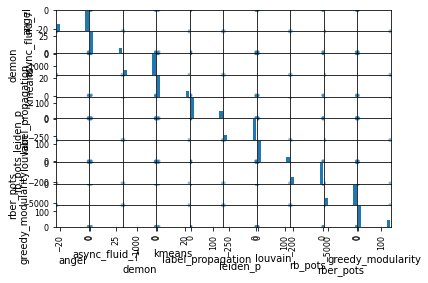

In [171]:

pd.plotting.scatter_matrix(m_df[['angel','async_fluid_7', 'demon',
       'kmeans', 'label_propagation', 'leiden_p', 'louvain',
       'rb_pots', 'rber_pots', 'greedy_modularity']])
plt.show()

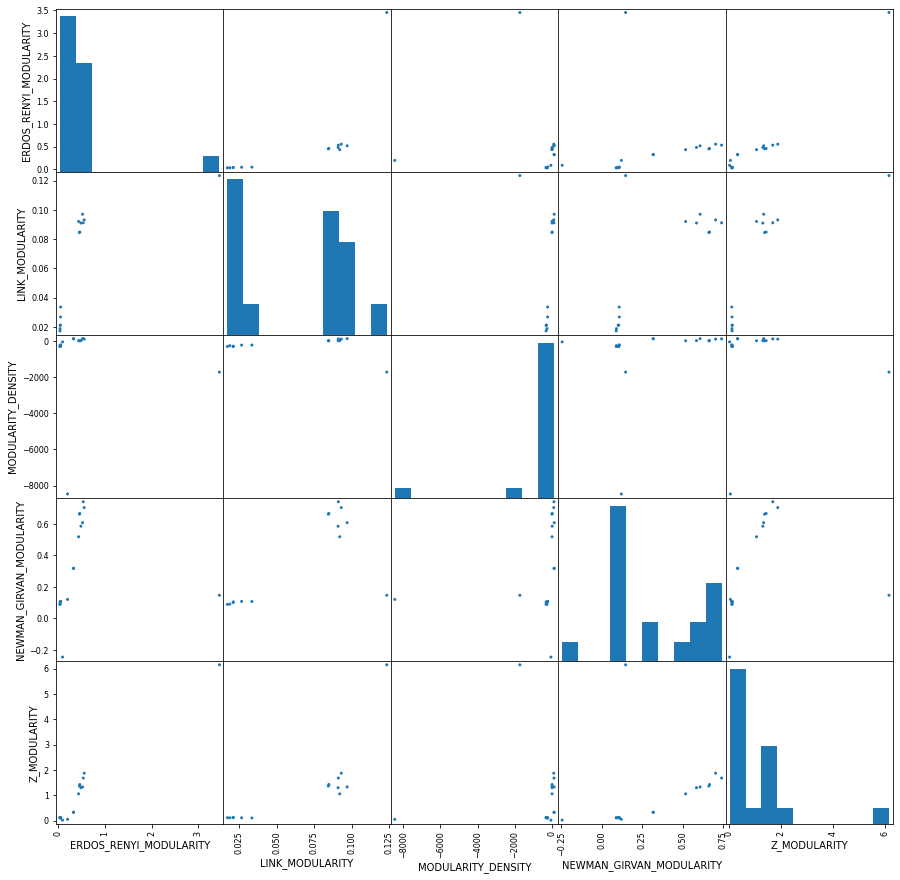

In [25]:

pd.plotting.scatter_matrix(m_df.transpose(),figsize=(15,15),alpha = 1)
plt.show()